In [1]:
import os
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import random
from sklearn.model_selection import train_test_split
# import rioxarray as rxr
# import earthpy.plot as ep
# import cartopy.crs as ccrs

In [2]:
def scaleCCMinMax(x):
    return(x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2))

### Read in all data & Visual check & Convert to table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


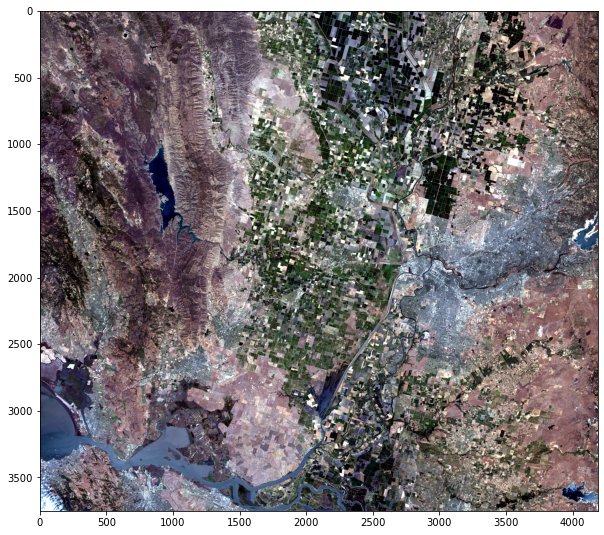

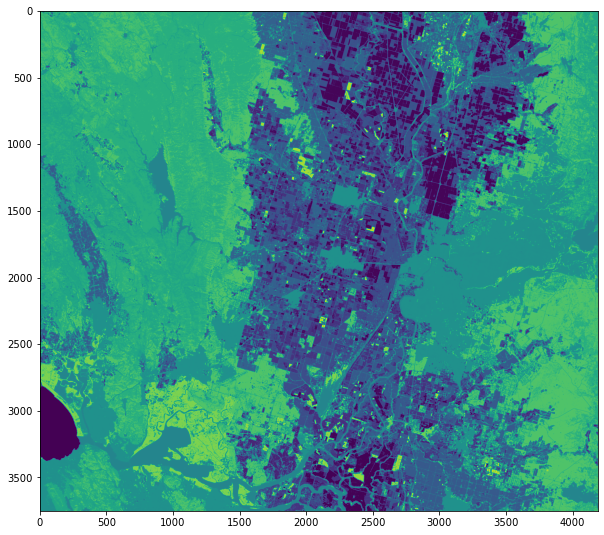

(3751, 4188, 9)
(9, 4188, 3751)
(15709188, 9)


In [90]:
raster_dir = '../data/Data'

for file in os.listdir(raster_dir):
    if file.endswith('SRB1_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        CAerosol = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB2_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        BLUE = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB3_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        GREEN = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB4_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        RED = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB5_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        NIR = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB6_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR1 = raster.GetRasterBand(1).ReadAsArray()/10000
    elif file.endswith('SRB7_clip.tif'):
        raster = gdal.Open(os.path.join(raster_dir, file))
        SWIR2 = raster.GetRasterBand(1).ReadAsArray()/10000

groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'
raster = gdal.Open(groundTruth_path)
groundTruth = raster.GetRasterBand(1).ReadAsArray()
        
raster_array = np.dstack((CAerosol, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, groundTruth, groundTruth))
Image_Pre_Check = np.dstack((scaleCCMinMax(raster_array[:, :, 3]), scaleCCMinMax(raster_array[:, :, 2]), scaleCCMinMax(raster_array[:, :, 1])))
plt.figure(figsize=(10, 10))
plt.imshow(Image_Pre_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(raster_array[:, :, 7])
plt.show()

print(raster_array.shape)

raster_array_t = raster_array.transpose()
print(raster_array_t.shape)

raster_array_table = raster_array_t.reshape(raster_array_t.shape[0], (raster_array_t.shape[1]*raster_array_t.shape[2])).transpose()
print(raster_array_table.shape)

### Prepare Training label

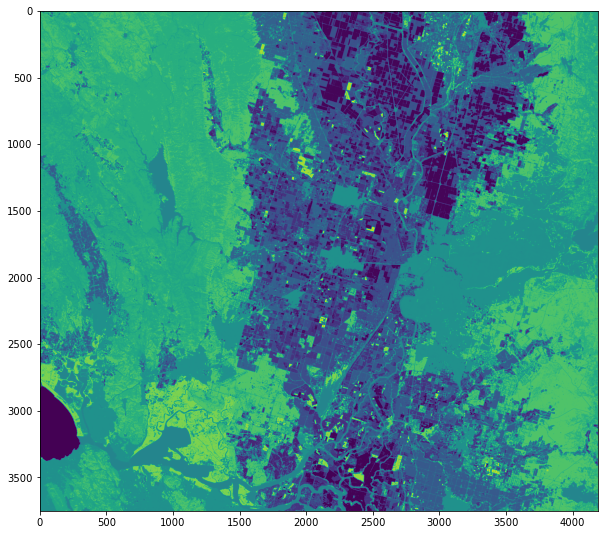

(3751, 4188)
(15709188, 1)


In [52]:
# groundTruth_path = '../data/GroundTruth/CDL_2021_06_clip.tif'

# raster = gdal.Open(groundTruth_path)
# groundTruth = raster.GetRasterBand(1).ReadAsArray()

# plt.figure(figsize=(10, 10))
# plt.imshow(groundTruth)
# plt.show()

# print(groundTruth.shape)

# groundTruth_table = groundTruth.reshape(1, (groundTruth.shape[0]*groundTruth.shape[1])).transpose()
# print(groundTruth_table.shape)

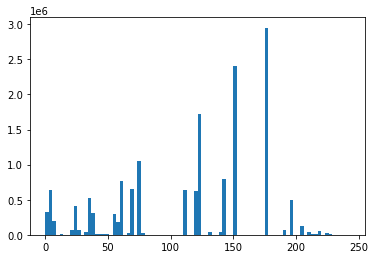

[  0   1   2   3   4   5   6  12  13  14  21  22  23  24  27  28  29  31
  33  36  37  39  42  43  44  46  47  48  49  50  51  53  54  57  58  59
  61  66  67  68  69  70  71  72  74  75  76  77  92 111 112 121 122 123
 124 131 141 142 143 152 176 190 195 204 205 206 208 209 211 212 213 214
 216 217 218 219 220 221 222 224 225 226 227 228 229 236 242 243]
88


In [53]:
# plt.figure()
# plt.hist(groundTruth.flatten(), bins = 86)
# plt.show()

# print(np.unique(groundTruth.flatten()))
# print(len(np.unique(groundTruth.flatten())))

In [91]:
groundTruth_df = pd.DataFrame(raster_array_table[:, 7])
table = pd.DataFrame(groundTruth_df.groupby([0]).size())

table['groundType'] = ['Water', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans', 'unflower', 'Sweet Corn', 'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat', 'Winter Wheat', 'Rye', 'Oats', 'Millet', 'Canola', 'Safflower', 'Alfalfa', 
                       'Other Hay/Non Alfalfa', 'Buckwheat', 'Sugarbeets', 'Botatoes', 'Other Crops', 'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions', 'Cucumbers', 'Chick Peas', 'Peas', 'Tomatoes', 'Herbs', 'Clover/Wildflowers', 
                       'Sod/grass Seed', 'Fllow/Idle Cropland', 'Cherries', 'Peaches', 'Apples', 'Grapes', 'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans', 'Almonds', 'Walnuts', 'Pears', 'Aquaculture', 'Open Water', 'Perennial Ice/Snow', 
                       'Developed/Open Space', 'Developed/Low Intensity', 'Developed/Med Intensity', 'Developed/High Intensity', 'Barren', 'Decodipis Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland', 'Grassland/Pasture', 'Woody Wetlands', 
                       'Herbaceous Wetlands', 'Pistachios', 'Triticale', 'Carrots', 'Garlic', 'Cantaloupes', 'Olives', 'Oranges', 'Honeydew Meions', 'Broccoli', 'Peppers', 'Pomegranates', 'Nectarines', 'Greens', 'Plums', 'Strawberries', 'Squash', 'Vetch', 
                       'Dbl Crop WinWht/Corn', 'Dbi Crop Oats/Corn', 'Lettuce', 'Dbl Crop Triticale/Corn', 'Pumpkins', 'Dbl Crop Winwht/Sorghum', 'Blueberries', 'Cabbage']
table['reclassify'] = ['Water', 'Corn', 'Other Crops', 'Rice', 'Wheat', 'GroundVege', 'Flower', 'Corn', 'Corn', 'Alfalfa', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Wheat', 'Flower', 'Flower', 'Alfalfa', 'Hay', 'Wheat', 'Tuber', 'Tuber', 'Other Crops', 'Tuber', 
                       'Other Crops', 'GroundVege', 'GroundVege', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege', 'Alfalfa', 'Flower', 'Grassland', 'Idle cropland', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'Grapes', 'FruitsTree', 'FruitsTree', 'FruitsTree', 'NutTree', 
                       'NutTree', 'NutTree', 'FruitsTree', 'Water', 'Water', 'Water', 'Urban', 'Urban', 'Urban', 'Urban', 'Barren', 'Forest', 'Forest', 'Forest', 'Shrubland', 'Grassland', 'Wetland', 'Wetland', 'NutTree', 'Wheat', 'GroundVege', 'GroundVege', 'GroundVege', 
                       'NutTree', 'FruitsTree', 'GroundVege', 'GroundVege', 'GroundVege', 'FruitsTree', 'FruitsTree', 'GroundVege', 'FruitsTree', 'Other Crops', 'GroundVege', 'Flower', 'Corn', 'Corn', 'GroundVege', 'Corn', 'GroundVege', 'Wheat', 'GroundVege', 'GroundVege']
table['Value_20'] = [2, 18, 20, 17, 16, 12, 15, 18, 18, 14, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 6, 16, 13, 13, 20, 13, 20, 12, 12, 12, 16, 12, 12, 14, 15, 5, 19, 10, 10, 10, 9, 10, 10, 10, 11, 11, 11, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 11, 
                     16, 12, 12, 12, 11, 10, 12, 12, 12, 10, 10, 12, 10, 20, 12, 15, 18, 18, 12, 18, 12, 16, 12, 12]
table['Value_12'] = [2, 11, 11, 11, 11, 9, 9, 11, 11, 9, 11, 11, 11, 11, 11, 11, 11, 9, 9, 9, 6, 11, 9, 9, 11, 9, 11, 9, 9, 9, 11, 9, 9, 9, 9, 5, 12, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 2, 2, 2, 3, 3, 3, 3, 1, 8, 8, 8, 7, 5, 4, 4, 10, 11, 9, 9, 9, 10, 
                     10, 9, 9, 9, 10, 10, 9, 10, 11, 9, 9, 11, 11, 9, 11, 9, 11, 9, 9]

table.to_csv('../data/GroundTruth/LandCover.csv')
table

0               groundType   reclassify  Value_20  Value_12
0                                                                      
0.0    117934                    Water        Water         2         2
1.0    209832                     Corn         Corn        18        11
2.0      1348                   Cotton  Other Crops        20        11
3.0    631669                     Rice         Rice        17        11
4.0      2207                  Sorghum        Wheat        16        11
...       ...                      ...          ...       ...       ...
228.0    4356  Dbl Crop Triticale/Corn         Corn        18        11
229.0     423                 Pumpkins   GroundVege        12         9
236.0    1138  Dbl Crop Winwht/Sorghum        Wheat        16        11
242.0       9              Blueberries   GroundVege        12         9
243.0     104                  Cabbage   GroundVege        12         9

[88 rows x 5 columns]

In [92]:
for index, row in table.iterrows():
    raster_array_table[:, 7][raster_array_table[:, 7] == index] = row['Value_20']
    raster_array_table[:, 8][raster_array_table[:, 8] == index] = row['Value_12']
print(np.unique(raster_array_table[:, 7].flatten()))
print(len(np.unique(raster_array_table[:, 7].flatten())))
print(np.unique(raster_array_table[:, 8].flatten()))
print(len(np.unique(raster_array_table[:, 8].flatten())))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
20
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
12


In [94]:
reclass_20_table = pd.DataFrame(pd.DataFrame(raster_array_table[:, 7]).groupby([0]).size())
reclass_20_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']

reclass_20_table['percentile'] = reclass_table[0] / np.sum(reclass_table[0])

print(np.sum(reclass_20_table['percentile']))
reclass_20_table['sample_size'] = np.round(reclass_20_table['percentile'] * 600000)
print(np.sum(reclass_20_table['sample_size']))
reclass_20_table

1.0
600002.0


0          Class  percentile  sample_size
0                                                    
1.0     41254         Barren    0.002626       1576.0
2.0    644420          Water    0.041022      24613.0
3.0   2347088          Urban    0.149409      89645.0
4.0    565302        Wetland    0.035985      21591.0
5.0   2950765      Grassland    0.187837     112702.0
6.0    308647            Hay    0.019648      11789.0
7.0   2410539      Shrubland    0.153448      92069.0
8.0    831074         Forest    0.052904      31742.0
9.0    644888         Grapes    0.041052      24631.0
10.0   115825     FruitsTree    0.007373       4424.0
11.0  1107766        NutTree    0.070517      42310.0
12.0   338271     GroundVege    0.021533      12920.0
13.0    17529          Tuber    0.001116        670.0
14.0   522879        Alfalfa    0.033285      19971.0
15.0   432938         Flower    0.027560      16536.0
16.0   654523          Wheat    0.041665      24999.0
17.0   631669           Rice    0.040210      24126.0
18.0   241755           Corn    0.015389       9234.0
19.0   771604  Idle cropland    0.049118      29471.0
20.0   130452    Other Crops    0.008304       4983.0

In [95]:
reclass_12_table = pd.DataFrame(pd.DataFrame(raster_array_table[:, 8]).groupby([0]).size())
reclass_12_table['Class'] = ['Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Plant', 'Tree', 'Crop', 'Idle cropland']

reclass_12_table['percentile'] = reclass_table[0] / np.sum(reclass_table[0])

print(np.sum(reclass_12_table['percentile']))
reclass_12_table['sample_size'] = np.round(reclass_12_table['percentile'] * 600000)
print(np.sum(reclass_12_table['sample_size']))
reclass_12_table

0.7833529651564421
470012.0


0          Class  percentile  sample_size
0                                                    
1.0     41254         Barren    0.002626       1576.0
2.0    644420          Water    0.041022      24613.0
3.0   2347088          Urban    0.149409      89645.0
4.0    565302        Wetland    0.035985      21591.0
5.0   2950765      Grassland    0.187837     112702.0
6.0    308647            Hay    0.019648      11789.0
7.0   2410539      Shrubland    0.153448      92069.0
8.0    831074         Forest    0.052904      31742.0
9.0   1956516          Plant    0.041052      24631.0
10.0  1223591           Tree    0.007373       4424.0
11.0  1658388           Crop    0.070517      42310.0
12.0   771604  Idle cropland    0.021533      12920.0

### Prepare data for 20 classes

In [ ]:
label_index = []
for index, row in reclass_20_table.iterrows():
    label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

data = raster_array_table[label_index, 0:7]
print('Training data input shape: ' + str(data.shape))
label = raster_array_table[label_index, 7]
print('Training data label shape: ' + str(label.shape))

x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

print('Training data input shape: ' + str(x_train.shape))
print('Training data label shape: ' + str(y_train.shape))
print('Testing data input shape: ' + str(x_test.shape))
print('Testing data label shape: ' + str(y_test.shape))

### Prepare data for 12 classes

In [99]:
label_index = []
for index, row in reclass_12_table.iterrows():
    label_index.extend(groundTruth_table[groundTruth_table==index].sample(n=int(row['sample_size']), replace=False).index)
print('Random selected label index shape: ' + str(pd.DataFrame(label_index).shape))

data = raster_array_table[label_index, 0:7]
print('Training data input shape: ' + str(data.shape))
label = raster_array_table[label_index, 8]
print('Training data label shape: ' + str(label.shape))

x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.33, random_state=208)

print('Training data input shape: ' + str(x_train.shape))
print('Training data label shape: ' + str(y_train.shape))
print('Testing data input shape: ' + str(x_test.shape))
print('Testing data label shape: ' + str(y_test.shape))

Random selected label index shape: (470012, 1)
Training data input shape: (470012, 7)
Training data label shape: (470012,)
Training data input shape: (314908, 7)
Training data label shape: (314908,)
Testing data input shape: (155104, 7)
Testing data label shape: (155104,)


### Apply Machine Learning Method

In [97]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Random Forest Model

In [100]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

pred = rfc.predict(x_test)
print(metrics.classification_report(pred,y_test))

              precision    recall  f1-score   support

         1.0       0.04      0.79      0.07        19
         2.0       0.83      0.90      0.87      5743
         3.0       0.76      0.70      0.73     24921
         4.0       0.34      0.55      0.42      3434
         5.0       0.74      0.65      0.69     33317
         6.0       0.07      0.43      0.11       478
         7.0       0.70      0.61      0.65     27102
         8.0       0.58      0.66      0.62      7278
         9.0       0.71      0.58      0.64     23446
        10.0       0.49      0.55      0.52     10739
        11.0       0.63      0.72      0.67     14441
        12.0       0.29      0.54      0.38      4186

    accuracy                           0.64    155104
   macro avg       0.51      0.64      0.53    155104
weighted avg       0.68      0.64      0.66    155104



In [61]:
rfc = RandomForestClassifier()
parameters = {'n_estimators': range(30,80,10),'max_depth':range(3,10,2), 'min_samples_leaf':[5,6,7],'max_features':[1,2,3]}

grid_rfc = GridSearchCV(rfc,parameters,scoring='f1_macro')

grid_rfc.fit(x_train,y_train)

grid_rfc.best_params_,grid_rfc.best_score_

KeyboardInterrupt: 

In [102]:
pred_rfc = rfc.predict(raster_array_table[:, 0:7])
pred_rfc = np.expand_dims(pred_rfc, axis=1)
print(y.shape)
raster_array_table = np.append(raster_array_table, pred_rfc, axis=1)
print(raster_array_table)

(15709188, 1)
[[0.0612 0.08   0.1231 ... 3.     3.     9.    ]
 [0.0446 0.0624 0.0937 ... 3.     3.     7.    ]
 [0.0381 0.0509 0.0782 ... 7.     7.     7.    ]
 ...
 [0.0552 0.0739 0.1131 ... 5.     5.     5.    ]
 [0.0431 0.061  0.0951 ... 5.     5.     5.    ]
 [0.0423 0.0584 0.0927 ... 5.     5.     5.    ]]


### SVM Model

In [ ]:
# Train SVC model
clf = svm.LinearSVC(C = 1.0)
clf.fit(x_train, y_train)

pred_clf = clf.predict(x_test)
accuracy_score(y_test, pred_clf)

In [ ]:
pred_clf = rfc.predict(raster_array_table[:, 0:7])
pred_clf = np.expand_dims(pred_clf, axis=1)
print(pred_clf.shape)
raster_array_table = np.append(raster_array_table, pred_clf, axis=1)
print(raster_array_table)

### Convert prediction back to raster and visual check

(9, 15709188)
(9, 4188, 3751)
(3751, 4188, 9)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


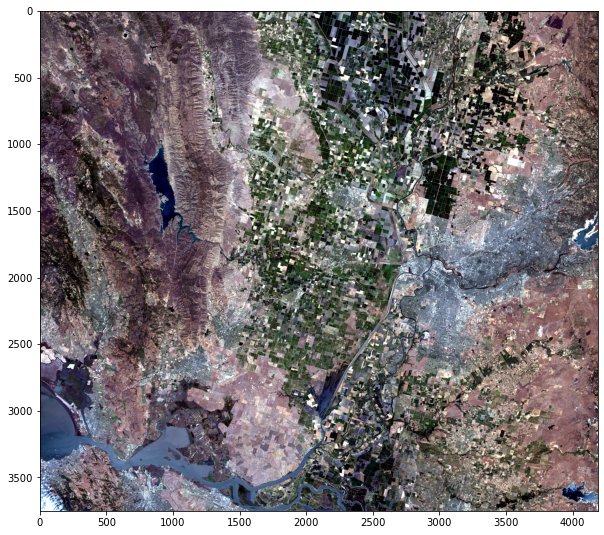

In [103]:
result_array_t = arr.transpose()
print(result_array_t.shape)

result_array = result_array_t.reshape(result_array_t.shape[0], raster_array_t.shape[1], raster_array_t.shape[2])
print(result_array.shape)

result = result_array.transpose()
print(result.shape)

Result_Check = np.dstack((scaleCCMinMax(result[:, :, 3]), scaleCCMinMax(result[:, :, 2]), scaleCCMinMax(result[:, :, 1])))

plt.figure(figsize=(10, 10))
plt.imshow(Result_Check)
# plt.savefig('../results/Image_Pre_Check.png')
plt.show()

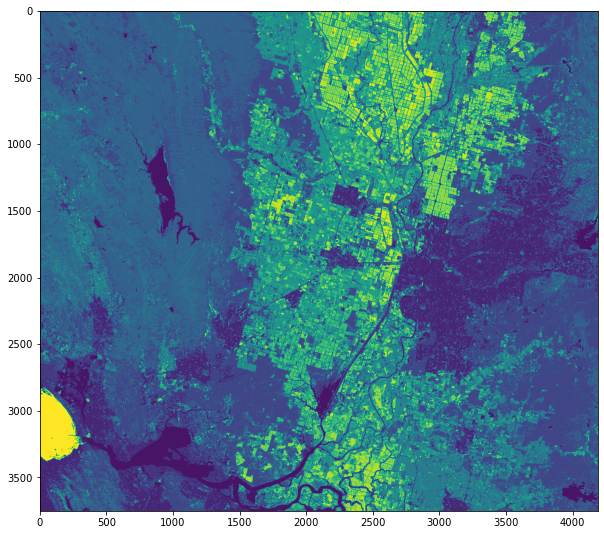

In [106]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 8])
plt.show()

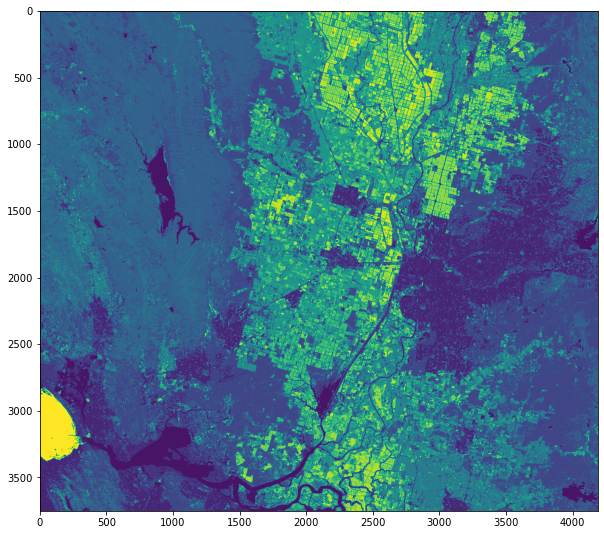

In [105]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 8])
plt.show()

(15709188,)
(3751, 4188)


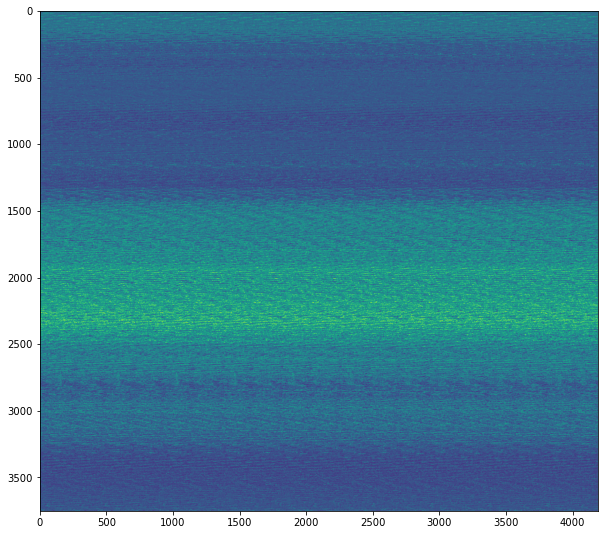

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:, :, 9])
plt.show()

In [ ]:
print(pred_clf.shape)

prediction_clf = pred_clf.transpose().reshape(groundTruth.shape[0], groundTruth.shape[1])
print(prediction_clf.shape)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_clf)
plt.show()

In [43]:
# class_labels = ['Background', 'Barren', 'Water', 'Urban', 'Wetland', 'Grassland', 'Hay', 'Shrubland', 'Forest', 'Grapes', 'FruitsTree', 'NutTree', 'GroundVege', 'Tuber', 'Alfalfa', 'Flower', 'Wheat', 'Rice', 'Corn', 'Idle cropland', 'Other Crops']
# colors = ['black', 'brown', 'blue', 'purple', 'cyan', 'lime', 'gold', 'green', 'forestgreen', 'seagreen', 'limegreen', 'lawngreen', 'yellowgreen', 'goldenrod', 'springgreen', 'red', 'oragne', 'tomato', 'darkorange', 'peru', 'grey']

# cmap = ListedColormap(colors)

# class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]
# norm = BoundaryNorm(class_bins, len(colors))

# xr.DataArray(prediction, coords=da.coords, dims=da.dims, attrs=da.attrs)

# f, ax = plt.subplots(figsize=(16, 16))
# im = prediction.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# # ep.draw_legend(im, titles=height_class_labels)
# ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
# ax.set_axis_off()
# plt.show()

# C:\Users\YunzZhu\.conda\envs\rangeland\python.exe -I"C:\Users\YunzZhu\.conda\envs\rangeland\Library\include\gdal.h" -lgdal_i -L"C:\Users\YunzZhu\.conda\envs\rangeland\Library\lib\gdal_i.lib" install GDAL-3.0.2-py3.9-win-amd64.egg-info

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 16))

# chm_plot = ax.imshow(lidar_chm,
#                      cmap=cmap,
#                      norm=norm)

# ax.set_title("Lidar Canopy Height Model (CHM)")

# # Add a legend for labels
# legend_labels = {"tan": "short", 
#                  "springgreen": "medium", 
#                  "darkgreen": "tall"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# ax.legend(handles=patches,
#           bbox_to_anchor=(1.35, 1),
#           facecolor="white")

# ax.set_axis_off()
# plt.show()